# Version 2.0

In [1]:
from io import open
import string
import numpy as np
import pandas as pd

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [446]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_genders + n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_genders + n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, gender, category, input, hidden, temperature=0.9):
        input_combined = torch.cat((gender, category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        # output = self.softmax(output)
        output = F.log_softmax(output/temperature, dim=1)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [447]:
df = pd.read_csv("../db/names.csv")
df.drop_duplicates(subset=['name'])
df.shape

(22200, 4)

In [448]:
df['race'].unique()

category_lines = {'Altmer':[], 'Argonian':[], 'Bosmer':[], 'Breton':[], 'Dunmer':[], 'Imperial':[],
       'Khajit':[], 'Nord':[], 'Orc':[], 'Redguard':[]}
all_categories = list(df['race'].unique())
for i in range(df.shape[0]):
    category = df.iloc[i]['race']
    category_lines[category].append(df.iloc[i]['name'])

n_categories = len(all_categories)

In [449]:
n_genders = 2
all_genders = ['male', 'female']
def genderTensor(gender):
    li = all_genders.index(gender)
    tensor = torch.zeros(1, n_genders)
    tensor[0][li] = 1
    return tensor

In [450]:
genderTensor("female")

tensor([[0., 1.]])

In [451]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingTriplet():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    gender = df[df['name'] == line].gender.values[0]
    return gender, category, line

In [452]:
randomTrainingTriplet()

('male', 'Khajit', 'Nurad')

In [453]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    gender, category, line = randomTrainingTriplet()
    gender_tensor = genderTensor(gender)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return gender_tensor, category_tensor, input_line_tensor, target_line_tensor

In [454]:
randomTrainingExample()

(tensor([[1., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [550]:
criterion = nn.NLLLoss()

learning_rate = 0.005
max_norm = 5

def train(gender_tensor, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(gender_tensor, category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=max_norm)

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [551]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [552]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 400000
print_every = 10000
plot_every = 500
all_losses = []
total_loss = 0 

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 46s (10000 2%) 2.5734
1m 32s (20000 5%) 3.1751
2m 18s (30000 7%) 1.7554
3m 3s (40000 10%) 2.5283
3m 50s (50000 12%) 3.3883
4m 36s (60000 15%) 1.7488
5m 22s (70000 17%) 2.0459
6m 8s (80000 20%) 2.9410
6m 54s (90000 22%) 1.6515
7m 39s (100000 25%) 2.2615
8m 25s (110000 27%) 1.7843
9m 11s (120000 30%) 2.2598
9m 57s (130000 32%) 2.5571
10m 42s (140000 35%) 2.2787
11m 28s (150000 37%) 1.8860
12m 15s (160000 40%) 1.7259
12m 59s (170000 42%) 1.8715
13m 43s (180000 45%) 2.7874
14m 26s (190000 47%) 1.5360
15m 9s (200000 50%) 2.5165
15m 53s (210000 52%) 1.9558
16m 36s (220000 55%) 2.0030
17m 20s (230000 57%) 1.5957
18m 3s (240000 60%) 2.3462
18m 47s (250000 62%) 2.0208
19m 30s (260000 65%) 2.4180
20m 14s (270000 67%) 2.0517
20m 58s (280000 70%) 1.7263
21m 42s (290000 72%) 2.1410
22m 26s (300000 75%) 1.6151
23m 10s (310000 77%) 1.4164
23m 54s (320000 80%) 2.3796
24m 40s (330000 82%) 1.4506
25m 27s (340000 85%) 2.3725
26m 13s (350000 87%) 2.2336
26m 58s (360000 90%) 1.9452
27m 43s (370000 92%) 

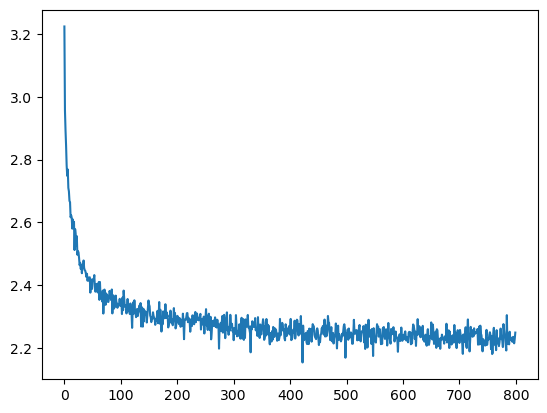

In [553]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [555]:
max_length = 20

# Sample from a category and starting letter
def sample(gender, category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        gender_tensor = genderTensor(gender)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(gender_tensor, category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(gender, category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(gender, category, start_letter))

samples('male','Nord', 'HTU')

samples('male','Imperial', 'ZT')

samples('female','Breton', 'SSS')

samples('male','Khajit', 'R')

Haldir
Thoril
Uril
Zalis
Tarinus
Saline
Salin
Salin
Razari


In [556]:
import torch.nn.functional as F

def sample_from_model(rnn, gender, category, start_letter='A', max_length=20, temperature=1.0):
    with torch.no_grad():
        input_tensor = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(gender, category, input_tensor[0], hidden)
            probabilities = F.softmax(output / temperature, dim=1)
            
            # Use probabilistic random sampling to choose the next character
            sampled_index = torch.multinomial(probabilities.squeeze(), 1)
            # print(probabilities.squeeze())
            # print(sampled_index)

            if sampled_index == 58:
                break
            else:
                sampled_char = all_letters[sampled_index.item()]
                output_name += sampled_char
            input_tensor = inputTensor(sampled_char)

        return output_name

In [699]:
# After training
sampled_name = sample_from_model(rnn, genderTensor("male"), categoryTensor('Imperial'), start_letter='T', temperature=0.8)
print(sampled_name)

Tarulusuu


In [544]:

torch.save(rnn, "model/model_2.pth")